# Install monai

https://www.kaggle.com/code/satnam007/gan-on-3d-images/notebook#Generative-Adversarial-Networks-in-PyTorch

In [1]:
!pip install monai

In [2]:
!pip install tqdm

# Imports

In [3]:
import os
import nibabel as nib
from pathlib import Path
import SimpleITK as sitk
import monai
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from monai.data import CacheDataset, DataLoader, pad_list_data_collate
from monai.transforms import Compose,Spacingd,RandSpatialCropd,EnsureChannelFirstd,ScaleIntensityd,ScaleIntensityRanged,LoadImaged

# Load images, process and save them
This step resampled the images to a lower resolution of (1.0 × 1.0 × 1.5) mm, and performed a random crop to extract a smaller region based on a randomly selected coordinate.

Normalization process is different for CT and for MRI scans:

ct: The intensity range for CT scans is clipped to [-1024, 1650]. This range corresponds to the Hounsfield Unit (HU) 

mri: Unlike CT, MRI voxel intensities do not have a standard quantitative scale (like HU for CT) for T2 sequences. The range and units of MRI intensities vary based on the imaging protocol and machine. The intensities of MRI scans are normalized independently for each scan to the range [-1, 1].

In [14]:
def load_images(directory_pelvis: str,output_folder="../processed_data", device=None):
    """
    Load MRI and CT images, preprocess them, and return preprocessed pairs on the specified device.

    Args:
        directory_pelvis (str): Path to the dataset directory.
        device (torch.device): Device to which the tensors will be moved (e.g., 'cuda' or 'cpu').

    Returns:
        list: A list of dictionaries containing preprocessed 'mr' and 'ct' images.
    """
    
    # Default to CPU if no device is specified
    if device is None:
        device = torch.device("cpu")
        
    os.makedirs(output_folder, exist_ok=True)

    dataset = []
    patient_folder_name = []
    
    for folder_patient in os.listdir(directory_pelvis)[:10]:
        print(folder_patient)
        folder_path = Path(folder_patient) 
        patient_folder_name.append(folder_path.stem[:6])
        #print(patient_folder_name)
        
        patient_path = os.path.join(directory_pelvis, folder_patient)
        mri_path = os.path.join(patient_path, "mr.nii.gz")
        ct_path = os.path.join(patient_path, "ct.nii.gz")

        if os.path.exists(mri_path) and os.path.exists(ct_path):
            dataset.append({"mr": mri_path, "ct": ct_path})
    
    # Preprocess MRI and CT images
    transforms = Compose([
        LoadImaged(keys=["mr","ct"]),
        EnsureChannelFirstd(keys=["mr","ct"],channel_dim=0), # Ensure channel first [C, H, W, D]
        Spacingd(keys=["mr", "ct"], pixdim=(1.0, 1.0, 1.5)), # Resample spacing
        ScaleIntensityd(keys=["mr"], minv=-1, maxv=1.0), 
        ScaleIntensityRanged(
            keys=["ct"],
            a_min=-1024, a_max=1650,  # Clipping range for CT -> -1024 HU = air, 1650 HU = bone
            b_min=-1.0, b_max=1.0, clip=True # Normalization range, clipping reduces noise from irrelevant intensities
        )
    ])

    # Apply transformations using MONAI Dataset
    monai_dataset = CacheDataset(data=dataset, transform=transforms)
    #print(len(monai_dataset))
    train_dl = DataLoader(
        monai_dataset, 
        batch_size=1, 
        shuffle=True, 
        num_workers=0, 
        collate_fn=pad_list_data_collate
    ) # to handle tensors of different sizes
    
    # Create a list to store processed images
    processed_images = []
    #print(len(patient_folder_name))

    # Iterate through the transformed dataset with patient names
    for item, patient_name in zip(monai_dataset, patient_folder_name):

        # Save each image in the output folder
        patient_folder = os.path.join(output_folder, patient_name)
        os.makedirs(patient_folder, exist_ok=True)

        # Save MRI with SimpleITK
        mri_filename = os.path.join(patient_folder, "mr_processed.nii.gz")
        #print(mri_filename)
        mri_image_processed = item["mr"].cpu().numpy() 
        #print(mri_image_processed.shape)
        sitk.WriteImage(sitk.GetImageFromArray(mri_image_processed), mri_filename)
    
        # Save CT with SimpleITK
        ct_filename = os.path.join(patient_folder, "ct_processed.nii.gz")
        ct_image_processed = item["ct"].cpu().numpy()
        sitk.WriteImage(sitk.GetImageFromArray(ct_image_processed), ct_filename)
    
    return dataset, train_dl

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset, train_dl = load_images("C:\\Users\\catar\\OneDrive - Universidade de Coimbra\\Ambiente de Trabalho\\Master Thesis\\Code\\mythesisprojects\\datasets",output_folder="../processed_data",device=device)


1PA001
1PA004
1PA005
1PA009
1PA010
1PA011
1PA012
1PA014
1PA018
1PA019


Loading dataset: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


../processed_data\1PA001\mr_processed.nii.gz
(565, 338, 146)
../processed_data\1PA004\mr_processed.nii.gz
(457, 263, 149)
../processed_data\1PA005\mr_processed.nii.gz
(586, 410, 151)
../processed_data\1PA009\mr_processed.nii.gz
(470, 299, 134)
../processed_data\1PA010\mr_processed.nii.gz
(444, 312, 136)
../processed_data\1PA011\mr_processed.nii.gz
(514, 310, 146)
../processed_data\1PA012\mr_processed.nii.gz
(502, 348, 145)
../processed_data\1PA014\mr_processed.nii.gz
(568, 392, 147)
../processed_data\1PA018\mr_processed.nii.gz
(428, 258, 147)
../processed_data\1PA019\mr_processed.nii.gz
(510, 254, 146)


In [9]:
for real_images in train_dl:
    print("MR:",real_images['mr'].shape)
    print("CT:",real_images['ct'].shape)
    #print({real_images['mr'][0]-real_images['mr'][1]})  

MR: torch.Size([1, 502, 348, 145])
CT: torch.Size([1, 502, 348, 145])
MR: torch.Size([1, 568, 392, 147])
CT: torch.Size([1, 568, 392, 147])
MR: torch.Size([1, 565, 338, 146])
CT: torch.Size([1, 565, 338, 146])
MR: torch.Size([1, 510, 254, 146])
CT: torch.Size([1, 510, 254, 146])
MR: torch.Size([1, 444, 312, 136])
CT: torch.Size([1, 444, 312, 136])
MR: torch.Size([1, 514, 310, 146])
CT: torch.Size([1, 514, 310, 146])
MR: torch.Size([1, 586, 410, 151])
CT: torch.Size([1, 586, 410, 151])
MR: torch.Size([1, 457, 263, 149])
CT: torch.Size([1, 457, 263, 149])
MR: torch.Size([1, 428, 258, 147])
CT: torch.Size([1, 428, 258, 147])
MR: torch.Size([1, 470, 299, 134])
CT: torch.Size([1, 470, 299, 134])


# Visualize 2D slices from paired images

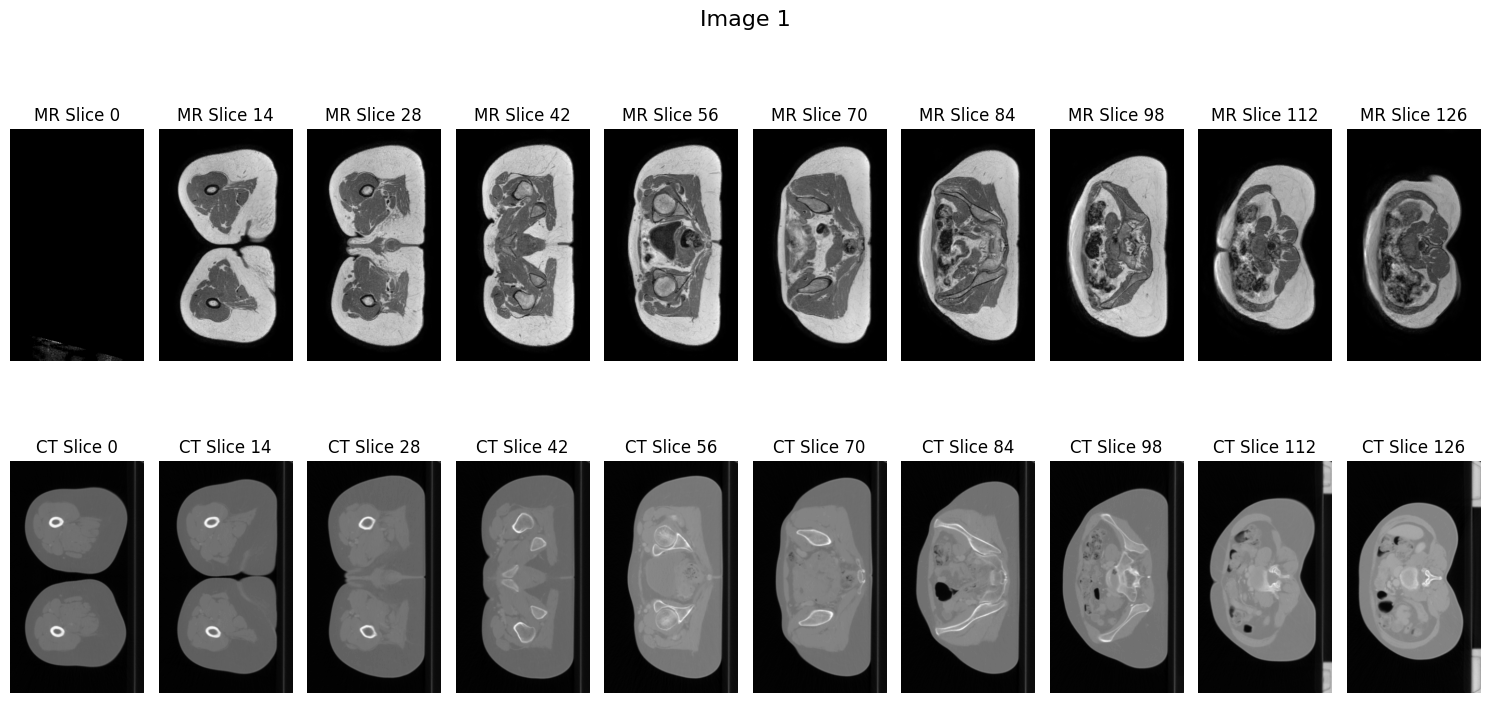

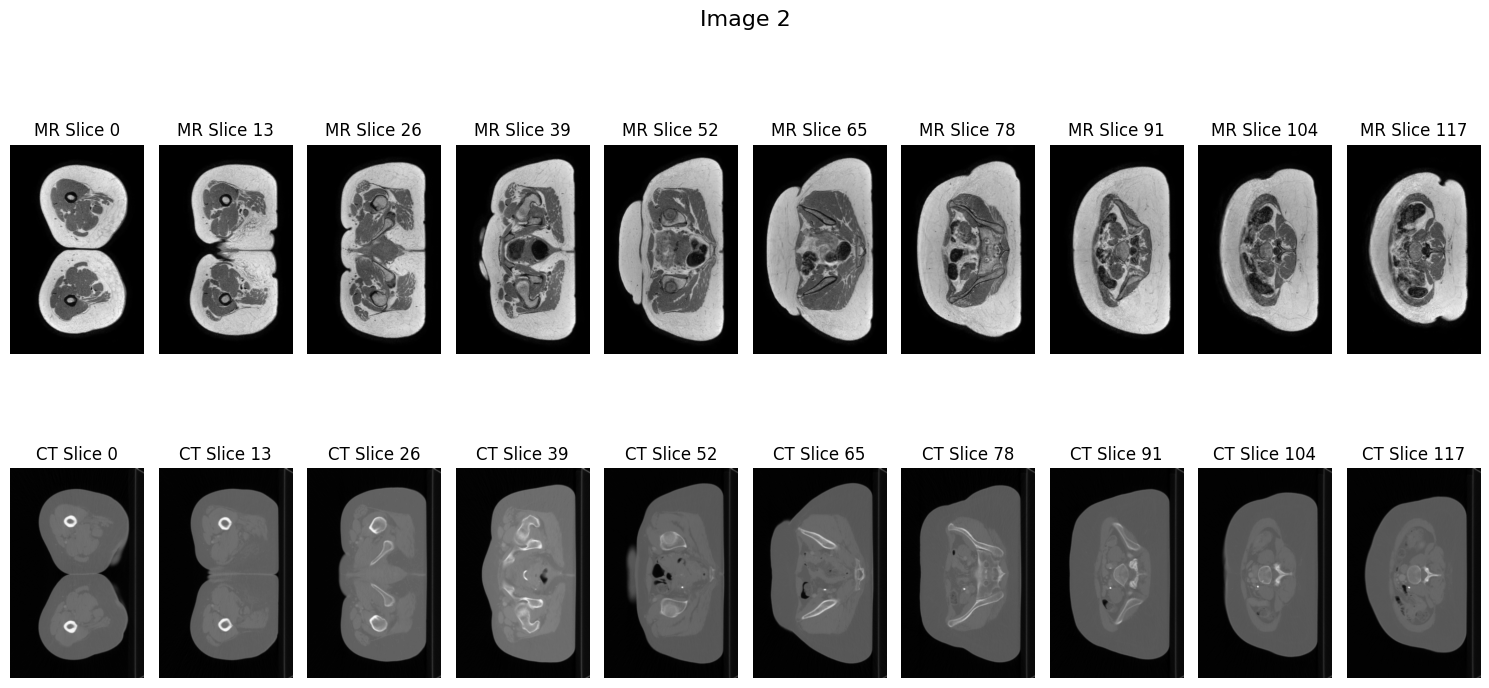

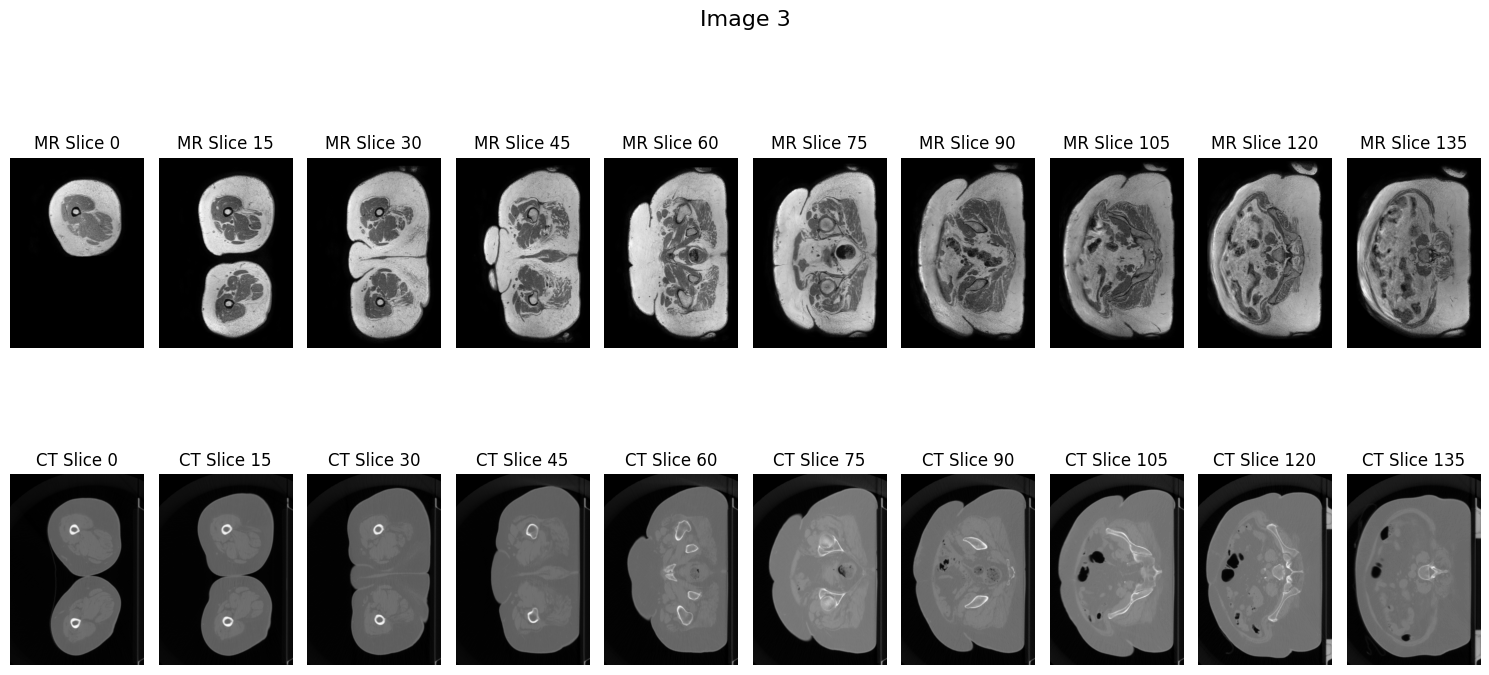

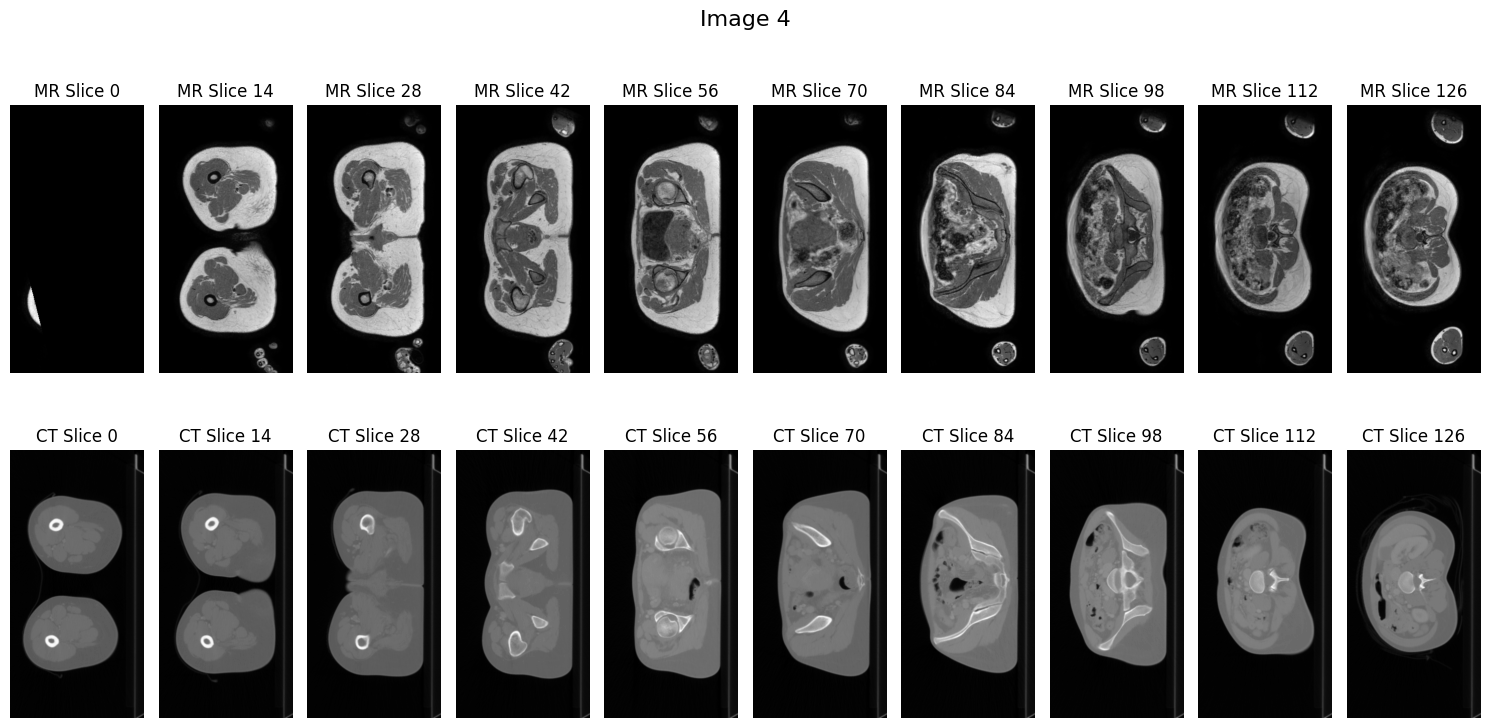

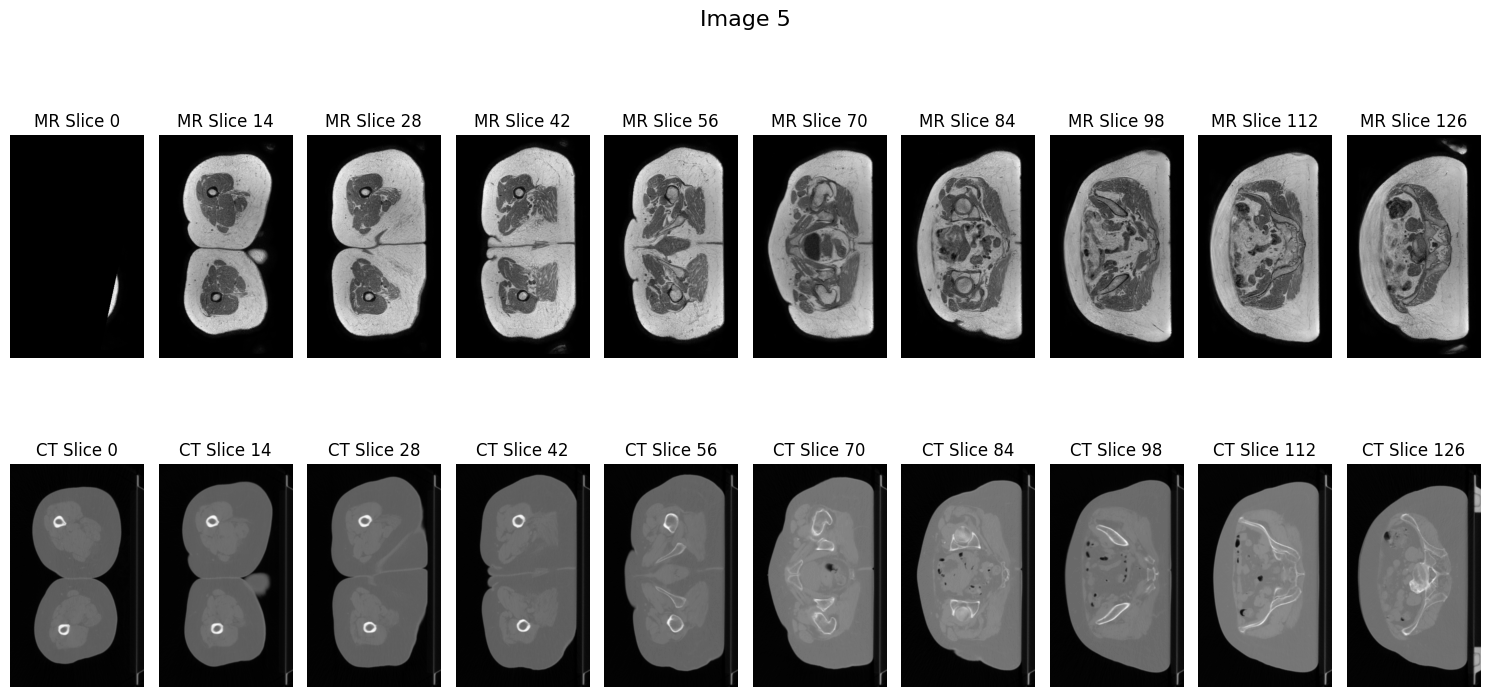

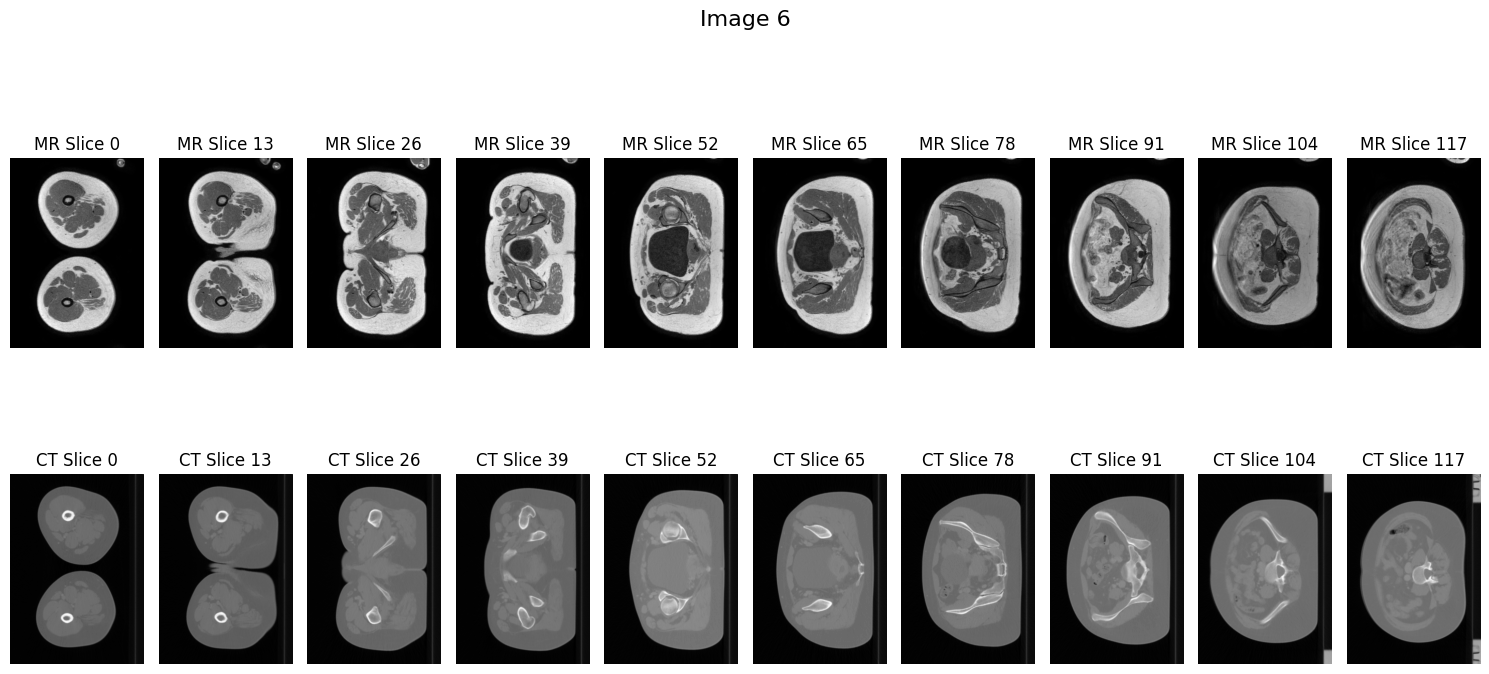

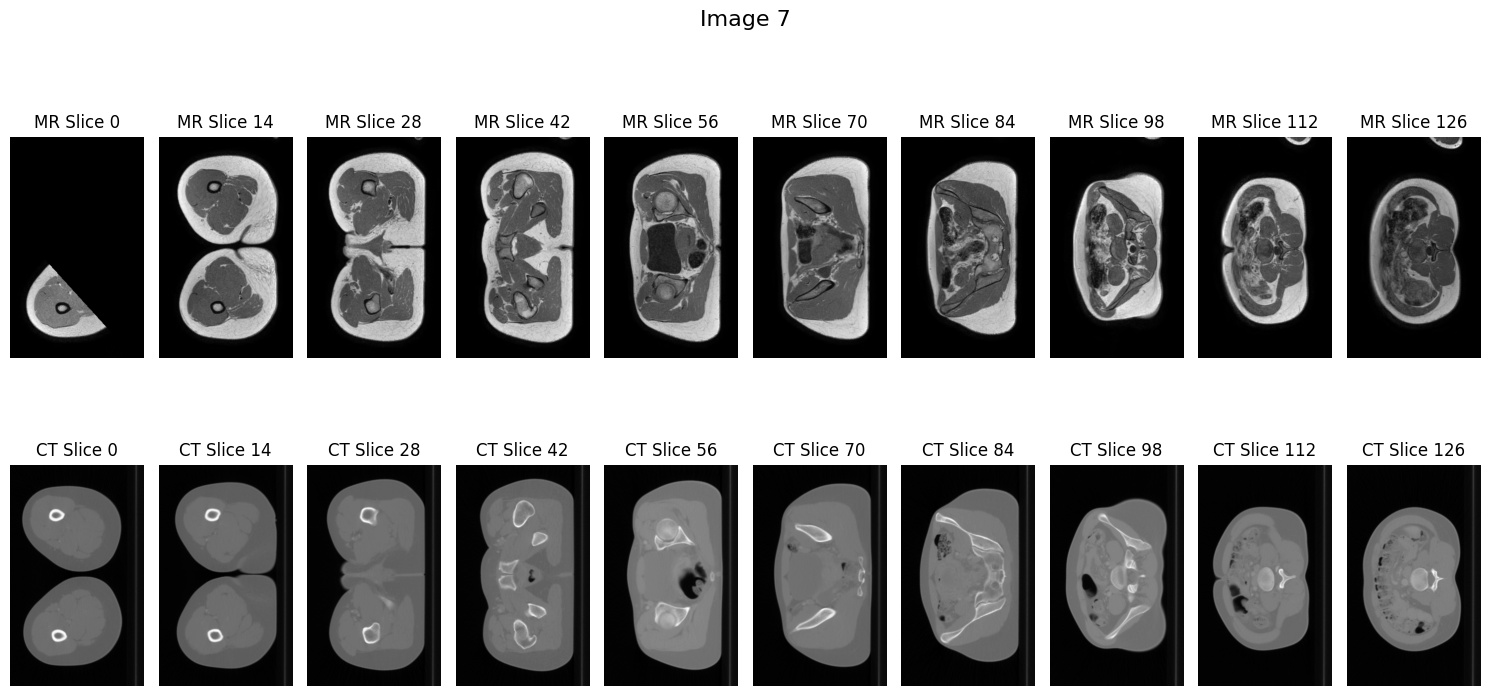

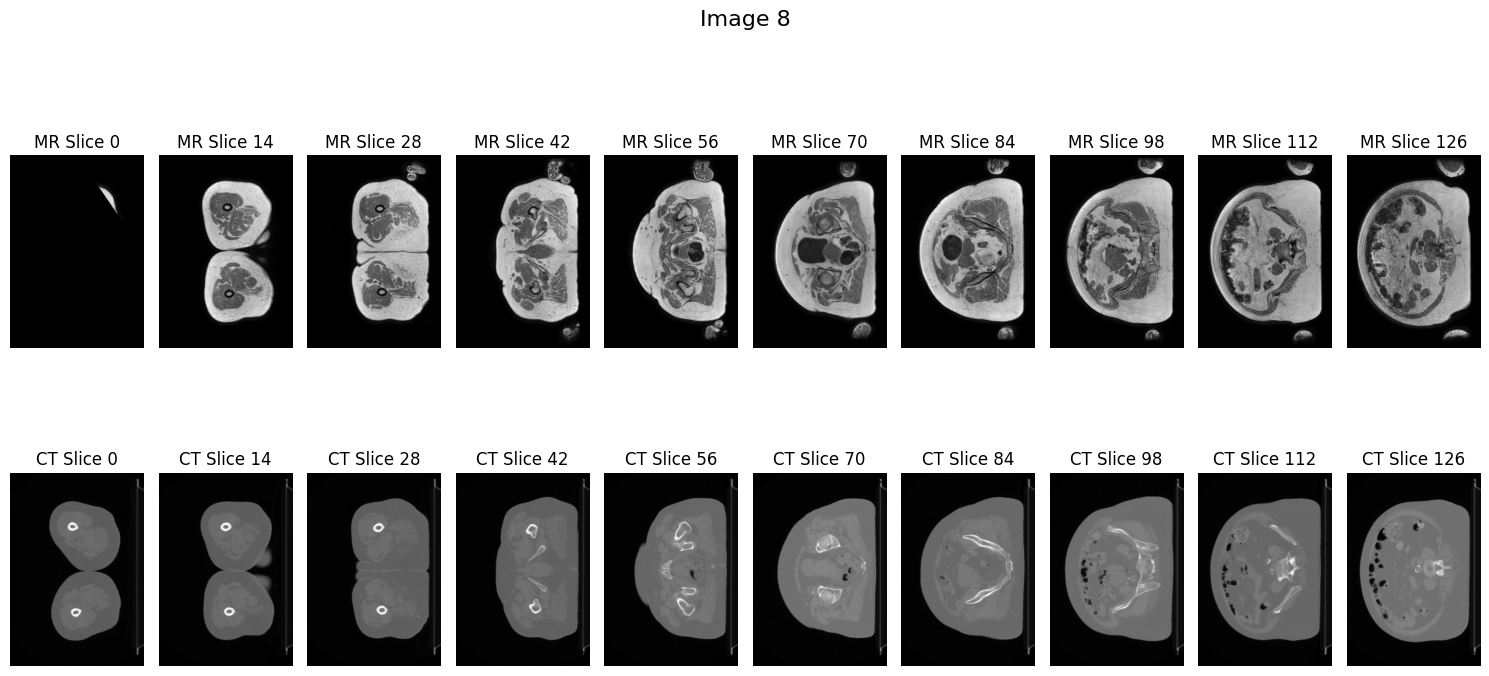

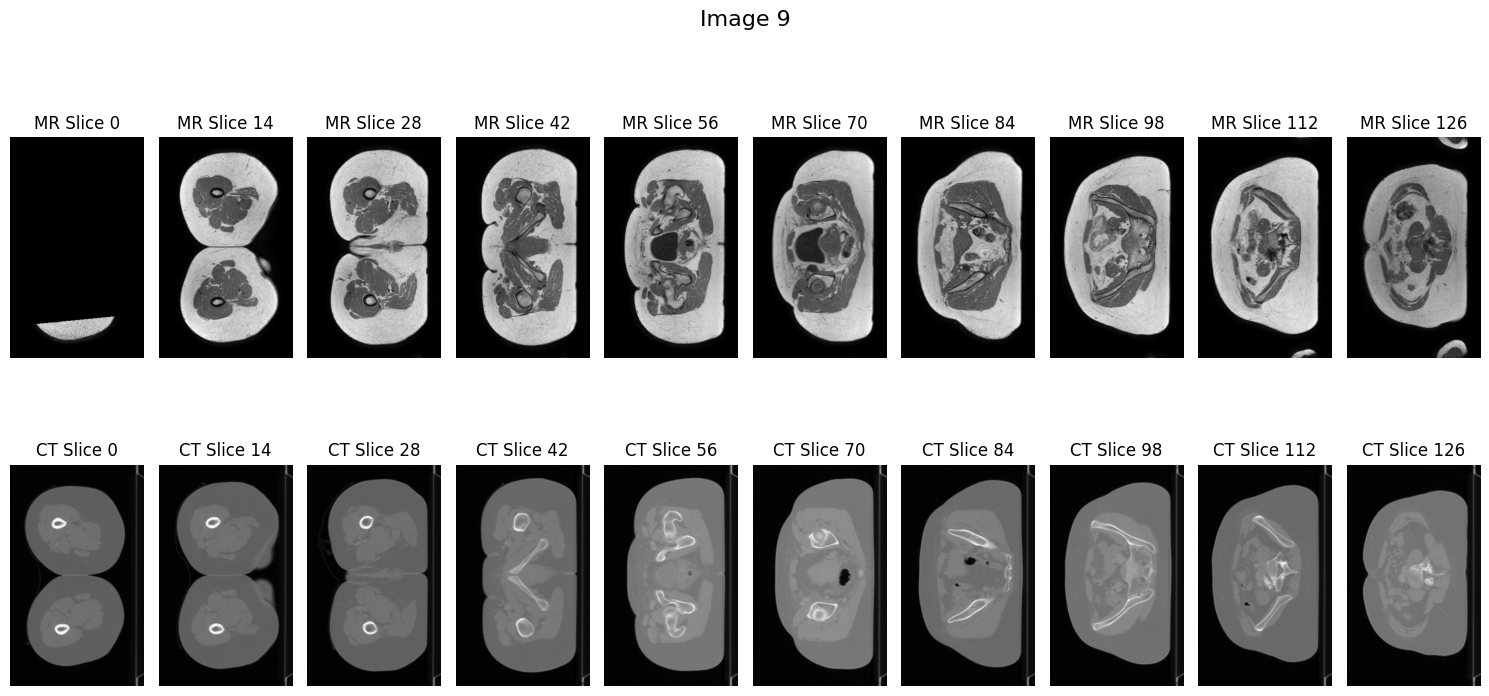

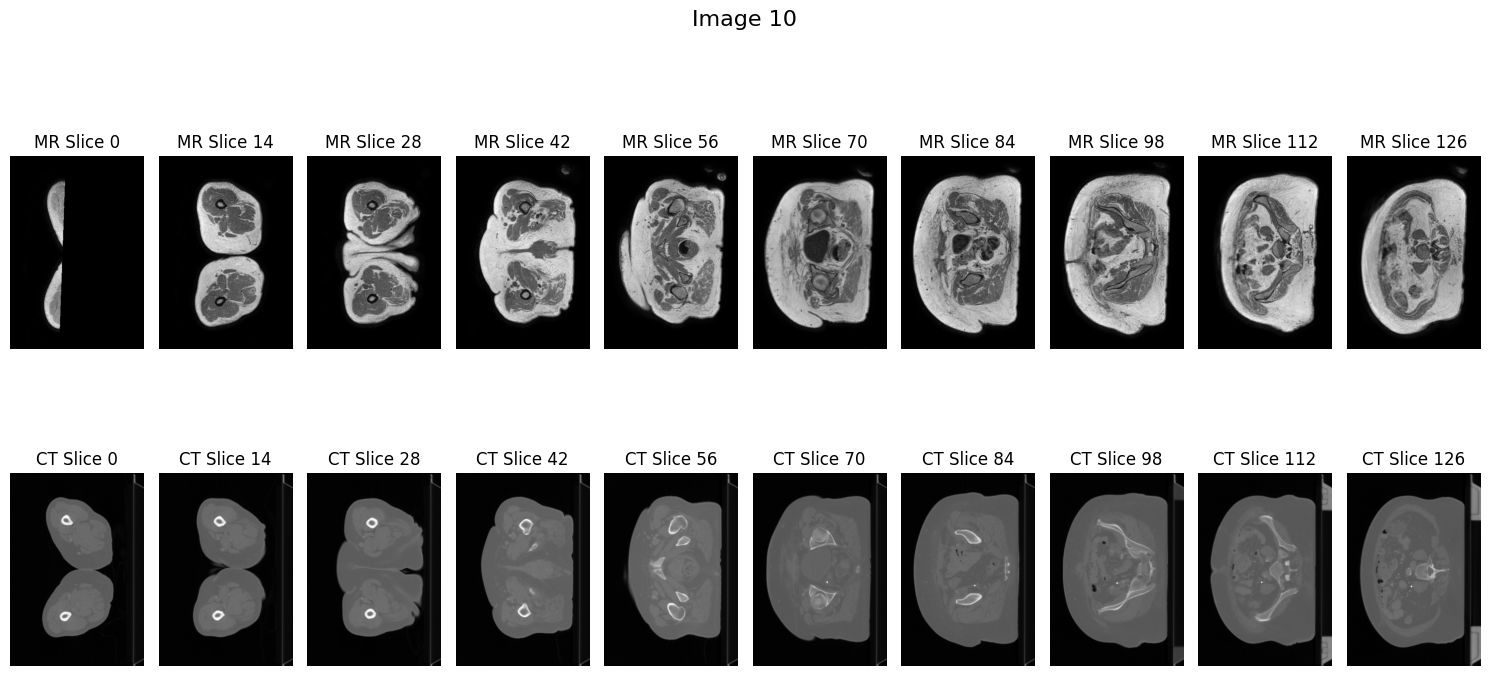

In [13]:
def visualize_batch(train_dl, num_slices=5):
    """
    Visualize MRI and CT images from the DataLoader.

    Args:
        train_dl (DataLoader): DataLoader containing processed batches.
        num_slices (int): Number of slices to visualize per image.
    """
    for item_idx, item in enumerate(train_dl):
        
        mr_item = item["mr"]  # Shape: [C, H, W, D]
        ct_item = item["ct"]  # Shape: [C, H, W, D]
        
        mr_image = mr_item[0, :, :, :].cpu().numpy()  # Remove channel dimension [H, W, D]
        ct_image = ct_item[0, :, :, :].cpu().numpy()
            
        fig, axes = plt.subplots(2, num_slices, figsize=(15, 8))
        fig.suptitle(f"Image {item_idx + 1}", fontsize=16)
            
        slice_positions = [i * (mr_image.shape[2] // num_slices) for i in range(num_slices)]
            
        # Slices of MRI
        for col_idx, slice_idx in enumerate(slice_positions):
            axes[0, col_idx].imshow(mr_image[:, :, slice_idx], cmap='gray')
            axes[0, col_idx].set_title(f'MR Slice {slice_idx}')
            axes[0, col_idx].axis('off')
            
        # Slices of CT
        for col_idx, slice_idx in enumerate(slice_positions):
            axes[1, col_idx].imshow(ct_image[:, :, slice_idx], cmap='gray')
            axes[1, col_idx].set_title(f'CT Slice {slice_idx}')
            axes[1, col_idx].axis('off')
            
        axes[0, 0].set_ylabel('MRI', fontsize=12)
        axes[1, 0].set_ylabel('CT', fontsize=12)
            
        plt.tight_layout()
        plt.show()
            
visualize_batch(train_dl, num_slices=10)
